# Training U-net convolution network for image segmentation


## Work flow
1. Generate training data (can be done using the Annotate widget in napari-MM3).


2. [Import our images](#importimages).
    * The images are put into a generator so they are not loaded all at the same time. 
    * The generator will "augment" the images for training, that is, it will transform them in a number of ways to artificially increase the pool of training data to draw from. 
    * The image dimensions must be powers of two, based on how they are convolved. 
    
    
3. [Build the model](#buildmodel).
    * Set up the covolution, ReLU, max pooling, and other operations that dictate how our images are modified. 
    * The number of layers in the network is dictated by the image size. 
    * We also define our own custom loss functions. The loss function is a measure of how different the predicted labels are from the actual labels. Training means iteratively improving the model to minimize the loss.  
    
    
4. [Train the model](#trainmodel).
    * This step takes awhile. 
    * We will output a graph that plots the loss over training steps.
    
    
5. Use the notebook segment_cells_demo.ipynb to predict masks for images using the model. 

## Load modules

In [50]:
import os
import glob
import time
import numpy as np
from re import search, match

# image modules
# import png # can pip this package to save pngs at any bitsize
from scipy import ndimage as ndi # use for binary_fill_holes
from skimage import morphology # use for remove small objects
from skimage.external import tifffile as tiff
from pprint import pprint

# learning modules
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.keras.backend import log
from skimage.external import tifffile as tiff

# plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (8,8)

## Load images
* Get the mask names. Use the name to find the associated images in the channel stacks.
* When loading in masks convert to 16-bit. 
* Make a dictionary that holds both the mask and the associated raw 16-bit tif.  

In [2]:
mask_source_path = ''
mask_files = glob.glob(os.path.join(mask_source_path, '*.tif'))
mask_files = [name.split('/')[-1] for name in mask_files]

channels_path = ''

image_dict = {mask_file : dict(mask=None,
                               phase=None) for mask_file in mask_files}

for mask_file, image_pair_dict in image_dict.items():
    
    # load mask and put it in the little dictionary. Convert to 16bit
    with tiff.TiffFile(os.path.join(mask_source_path, mask_file)) as tif:
        image_pair_dict['mask'] = tif.asarray()
    
    # the following assumes your images are named as '(some string)_xy(fov#)_p(peak#)_t(time).tif'
    exp_id = mask_file.split('_xy')[0]
    # find phase contrast image
    match_object = search('(?<=xy)(\d\d\d)_p(\d\d\d\d)_t(\d\d\d\d)', mask_file)
    fov_id = match_object.group(1)
    peak_id = match_object.group(2)
    t = match_object.group(3)
        
    phase_channel_file = '{}_xy{}_p{}_t{}.tif'.format(exp_id,fov_id, peak_id,t)
    
    # it's slow this way, opening them up all separately, but easier
    with tiff.TiffFile(os.path.join(channels_path, phase_channel_file)) as tif:
        #phase_stack = tif.asarray()
        image_pair_dict['phase'] = tif.asarray()
    

## Crop images
* Also remove small dots and fill holes for mask.
* Need to convert back to 16 bit because the morphological operations make binary images. 

In [3]:
target_image_size = (256, 32)

for file, image_pair_dict in image_dict.items():
    
    #crop images to fit target size
    image_pair_dict['mask'] = image_pair_dict['mask'][:target_image_size[0], :target_image_size[1]]
    image_pair_dict['mask'] = morphology.opening(image_pair_dict['mask'], selem=morphology.square(2))

    image_pair_dict['mask'] = morphology.remove_small_objects(image_pair_dict['mask'], min_size=10)

    image_pair_dict['mask'] = ndi.binary_fill_holes(image_pair_dict['mask']).astype(np.uint16)
    
    image_pair_dict['phase'] = image_pair_dict['phase'][:target_image_size[0], :target_image_size[1]]
    
    img_shape = np.shape(image_pair_dict['mask'])
    
    # if the images are shorter or narrower than target size, need to pad instead
    if img_shape[0]<target_image_size[0]:
        pad = (
           (np.ceil((target_image_size[0] - img_shape[0])/2.0).astype(int), 
            np.floor((target_image_size[0] - img_shape[0])/2.0).astype(int)),(0,0))
        
        image_pair_dict['mask'] = np.pad(image_pair_dict['mask'], pad_width=pad, mode='edge')
        image_pair_dict['phase'] = np.pad(image_pair_dict['phase'], pad_width=pad, mode='edge')
        
    if img_shape[1]<target_image_size[1]:
        pad = ((0,0),
           (np.ceil((target_image_size[1] - img_shape[1])/2.0).astype(int), 
            np.floor((target_image_size[1] - img_shape[1])/2.0).astype(int)),(0,0))
        
        image_pair_dict['mask'] = np.pad(image_pair_dict['mask'], pad_width=pad, mode='edge')
        image_pair_dict['phase'] = np.pad(image_pair_dict['phase'], pad_width=pad, mode='edge')

/usr/local/lib/python3.5/dist-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


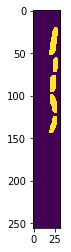

In [4]:
#check the masks look good
plt.imshow(image_pair_dict['mask'])

## Save images

In [5]:
image_dest_path = ''

mask_imgs = []
phase_imgs = []

for file, image_pair_dict in image_dict.items():
    mask_imgs.append(image_pair_dict['mask'])
    phase_imgs.append(image_pair_dict['phase'])
    
mask_imgs = np.stack(mask_imgs)
phase_imgs = np.stack(phase_imgs)

# increase axis of phase and mask by 1
mask_imgs = np.expand_dims(mask_imgs, -1)
phase_imgs = np.expand_dims(phase_imgs, -1)

with tiff.TiffWriter(os.path.join(image_dest_path, 'masks.tif'), imagej=False) as tif:
        tif.save(mask_imgs, photometric='minisblack')
        
with tiff.TiffWriter(os.path.join(image_dest_path, 'phase.tif'), imagej=False) as tif:
        tif.save(phase_imgs, photometric='minisblack')

## Load images if needed

In [36]:
#run this only if you are loading masks and images from a previous session

image_dest_path = './training_data_from_GUI/'

with tiff.TiffFile(os.path.join(image_dest_path, 'masks.tif')) as tif:
    mask_imgs = tif.asarray()
    
with tiff.TiffFile(os.path.join(image_dest_path, 'phase.tif')) as tif:
    phase_imgs = tif.asarray()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ryan/motherMachineSegger/training_data_from_GUI/masks.tif'

# Training the model

## Make generators

In [60]:
# we create two instances with the same arguments
train_data_gen_args = dict(
featurewise_center=False,
samplewise_center=True,
featurewise_std_normalization=False,
samplewise_std_normalization=True,
rotation_range=2,
width_shift_range=0.05,
height_shift_range=0.05,
brightness_range=None, # this seems to mess up the training
shear_range=2, 
zoom_range=0.1,
horizontal_flip=True,
vertical_flip=True,
data_format='channels_last',
fill_mode='constant') # there is just one channel for grayscale

train_image_datagen = ImageDataGenerator(**train_data_gen_args)

# we create two instances with the same arguments
train_mask_gen_args = dict(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
rotation_range=2,
width_shift_range=0.05,
height_shift_range=0.05,
brightness_range=None, # this seems to mess up the training
shear_range=2, 
zoom_range=0.1,
horizontal_flip=True,
vertical_flip=True,
data_format='channels_last',
fill_mode='constant') # there is just one channel for grayscale

train_mask_datagen = ImageDataGenerator(**train_mask_gen_args)

# Everything defaults to False or None. 
val_data_gen_args = dict(
featurewise_center=False,
samplewise_center=True,
featurewise_std_normalization=False,
samplewise_std_normalization=True) 

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_data_gen_args)

In [61]:
seed = 1
batch_size = 5
target_size = (256, 32)
training_frac = 0.8 # 80% for training, rest for validation
training_frac_int = int(np.around(len(mask_imgs)*training_frac, 0))
print(training_frac_int)


104


In [62]:
phase_imgs[:training_frac_int].shape

(104, 256, 32, 1)

## We need to define this new generator because zip doesn't work
* See https://github.com/keras-team/keras/issues/13123

In [63]:
def new_generator(a,b): #a,b are image and mask generators
    while 'shiv'=='shiv':
        a1 = a.next()
        b1 = b.next()
        yield(a1, b1)

In [64]:
train_image_generator = train_image_datagen.flow(x=phase_imgs[:training_frac_int],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

train_mask_generator = train_mask_datagen.flow(x=mask_imgs[:training_frac_int],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

train_generator = new_generator(train_image_generator, train_mask_generator)

val_image_generator = train_image_datagen.flow(x=phase_imgs[training_frac_int:],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

val_mask_generator = train_mask_datagen.flow(x=mask_imgs[training_frac_int:],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

val_generator = new_generator(val_image_generator, val_mask_generator)

## Visualize augmented images

In [65]:
aug_output_path = '/Users/ryan/growthlaw/unet/training_1011/augmented/'

try:
    os.makedirs(aug_output_path)
except:
    print(aug_output_path, 'already exists.')

for i in range(50):

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), squeeze=False)
    ax = axes.ravel()

    img = train_image_generator.next()[0,:,:,0]
    mask = train_mask_generator.next()[0,:,:,0]

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].imshow(mask, alpha=0.25, cmap=plt.cm.Greens)

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    fig.tight_layout()

    with tiff.TiffWriter(os.path.join(aug_output_path, '{:02d}.tif'.format(i)), imagej=False) as tif:
        tif.save(img, photometric='minisblack', compress=5)
    
    plt.close()

/Users/ryan/growthlaw/unet/training_1011/augmented/ already exists.


# Build the model using keras
* This is where we set of the U-net architecture of the model.
* The size and complexity of the model increase with more layers. I have found the small model (16) to work fine, but there is a lot more optimization that could be done.

### Layer functions

In [66]:
# define what happens at each layer
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder


In [67]:
# make the layers
inputs = layers.Input(shape=(target_size[0], target_size[1], 1))
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
center = conv_block(encoder3_pool, 512) # we were using 128 before
# center
# 32
decoder3 = decoder_block(center, encoder3, 256)
# 64
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
#outputs = layers.Conv2D(1, (1, 1), activation='tanh')(decoder0)

# make the model
model = models.Model(inputs=[inputs], outputs=[outputs])

## Loss functions

In [68]:
def dice_coeff(y_true, y_pred):
    smooth = 0.01 # originally 1. Make sure this is float. 
    score_factor = 2. # originally 2. Same, keep as float. 
    # Flatten
    y_true_f = tf.reshape(y_true, [-1]) # flattens tensor
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f) # sums the resulting product
    score = (score_factor * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def bce_modified(y_true, y_pred):
    return (1.0/2.0) * ((1-y_true) * log(1-y_pred) + (1+y_true) * log(1+y_pred))



## Compile the model and show us its structure

In [69]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
#model.compile(optimizer='adam', loss=bce_modified, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 32, 1)   0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 32, 32)  320         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_66 (Batc (None, 256, 32, 32)  128         conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 256, 32, 32)  0           batch_normalization_v1_66[0][0]  
__________________________________________________________________________________________________
conv2d_58 

## Save the model and set what the readout will be while it is training

In [70]:
save_model_path = '/Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', 
                                        save_best_only=True, verbose=1)

## Train model

In [71]:
epochs = 300 # number of iterations

In [72]:
print(time.asctime(time.localtime()))

# note the numbers for the steps are the number of images imported 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(train_image_generator.n/float(batch_size))),
    epochs=epochs,
    callbacks=[cp],
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_image_generator.n/float(batch_size))))

print(time.asctime(time.localtime()))

Tue Oct 13 12:29:50 2020
Epoch 1/300
6/6 [==============================] - 1s 179ms/step - loss: 6.0181 - dice_loss: 0.7979

Epoch 00001: val_dice_loss improved from inf to 0.79793, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 32s 2s/step - loss: 4.8972 - dice_loss: 0.5493 - val_loss: 6.0181 - val_dice_loss: 0.7979
Epoch 2/300
6/6 [==============================] - 1s 88ms/step - loss: 4.7449 - dice_loss: 0.6917

Epoch 00002: val_dice_loss improved from 0.79793 to 0.69171, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 12s 561ms/step - loss: 3.0587 - dice_loss: 0.4003 - val_loss: 4.7449 - val_dice_loss: 0.6917
Epoch 3/300
6/6 [==============================] - 1s 89ms/step - loss: 3.9578 - dice_loss: 0.6038

Epoch 00003: val_dice_loss improved from 0.69171 to 0.60380, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.h

Epoch 24/300
6/6 [==============================] - 1s 89ms/step - loss: 1.0403 - dice_loss: 0.1536

Epoch 00024: val_dice_loss improved from 0.15711 to 0.15357, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 12s 573ms/step - loss: 1.1529 - dice_loss: 0.1455 - val_loss: 1.0403 - val_dice_loss: 0.1536
Epoch 25/300
6/6 [==============================] - 1s 90ms/step - loss: 1.0231 - dice_loss: 0.1542

Epoch 00025: val_dice_loss did not improve from 0.15357
21/21 [==============================] - 11s 532ms/step - loss: 1.1040 - dice_loss: 0.1414 - val_loss: 1.0231 - val_dice_loss: 0.1542
Epoch 26/300
6/6 [==============================] - 1s 97ms/step - loss: 1.0197 - dice_loss: 0.1524

Epoch 00026: val_dice_loss improved from 0.15357 to 0.15244, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 13s 596ms/step - loss: 1.1096 - dice_loss: 0.1407 - va

Epoch 50/300
6/6 [==============================] - 1s 90ms/step - loss: 1.0308 - dice_loss: 0.1471

Epoch 00050: val_dice_loss did not improve from 0.13674
21/21 [==============================] - 11s 527ms/step - loss: 1.0734 - dice_loss: 0.1341 - val_loss: 1.0308 - val_dice_loss: 0.1471
Epoch 51/300
6/6 [==============================] - 1s 89ms/step - loss: 1.0354 - dice_loss: 0.1474

Epoch 00051: val_dice_loss did not improve from 0.13674
21/21 [==============================] - 11s 522ms/step - loss: 1.0616 - dice_loss: 0.1348 - val_loss: 1.0354 - val_dice_loss: 0.1474
Epoch 52/300
6/6 [==============================] - 1s 88ms/step - loss: 1.0527 - dice_loss: 0.1506

Epoch 00052: val_dice_loss did not improve from 0.13674
21/21 [==============================] - 11s 525ms/step - loss: 1.0319 - dice_loss: 0.1298 - val_loss: 1.0527 - val_dice_loss: 0.1506
Epoch 53/300
6/6 [==============================] - 0s 83ms/step - loss: 0.9505 - dice_loss: 0.1404

Epoch 00053: val_dice_loss

Epoch 78/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9415 - dice_loss: 0.1368

Epoch 00078: val_dice_loss did not improve from 0.13392
21/21 [==============================] - 11s 522ms/step - loss: 0.9867 - dice_loss: 0.1242 - val_loss: 0.9415 - val_dice_loss: 0.1368
Epoch 79/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9447 - dice_loss: 0.1350

Epoch 00079: val_dice_loss did not improve from 0.13392
21/21 [==============================] - 11s 529ms/step - loss: 0.9890 - dice_loss: 0.1243 - val_loss: 0.9447 - val_dice_loss: 0.1350
Epoch 80/300
6/6 [==============================] - 1s 89ms/step - loss: 0.9368 - dice_loss: 0.1373

Epoch 00080: val_dice_loss did not improve from 0.13392
21/21 [==============================] - 11s 527ms/step - loss: 0.9771 - dice_loss: 0.1233 - val_loss: 0.9368 - val_dice_loss: 0.1373
Epoch 81/300
6/6 [==============================] - 1s 87ms/step - loss: 0.9123 - dice_loss: 0.1338

Epoch 00081: val_dice_loss

Epoch 133/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9588 - dice_loss: 0.1384

Epoch 00133: val_dice_loss did not improve from 0.13134
21/21 [==============================] - 11s 522ms/step - loss: 0.9852 - dice_loss: 0.1240 - val_loss: 0.9588 - val_dice_loss: 0.1384
Epoch 134/300
6/6 [==============================] - 1s 88ms/step - loss: 1.0212 - dice_loss: 0.1421

Epoch 00134: val_dice_loss did not improve from 0.13134
21/21 [==============================] - 11s 536ms/step - loss: 0.9862 - dice_loss: 0.1237 - val_loss: 1.0212 - val_dice_loss: 0.1421
Epoch 135/300
6/6 [==============================] - 1s 89ms/step - loss: 0.9806 - dice_loss: 0.1393

Epoch 00135: val_dice_loss did not improve from 0.13134
21/21 [==============================] - 11s 525ms/step - loss: 0.9606 - dice_loss: 0.1218 - val_loss: 0.9806 - val_dice_loss: 0.1393
Epoch 136/300
6/6 [==============================] - 1s 86ms/step - loss: 1.0153 - dice_loss: 0.1442

Epoch 00136: val_dice_

Epoch 161/300
6/6 [==============================] - 1s 88ms/step - loss: 0.9776 - dice_loss: 0.1344

Epoch 00161: val_dice_loss did not improve from 0.13028
21/21 [==============================] - 11s 536ms/step - loss: 0.9097 - dice_loss: 0.1147 - val_loss: 0.9776 - val_dice_loss: 0.1344
Epoch 162/300
6/6 [==============================] - 1s 89ms/step - loss: 0.9247 - dice_loss: 0.1315

Epoch 00162: val_dice_loss did not improve from 0.13028
21/21 [==============================] - 11s 525ms/step - loss: 0.8962 - dice_loss: 0.1134 - val_loss: 0.9247 - val_dice_loss: 0.1315
Epoch 163/300
6/6 [==============================] - 1s 88ms/step - loss: 0.9505 - dice_loss: 0.1357

Epoch 00163: val_dice_loss did not improve from 0.13028
21/21 [==============================] - 11s 532ms/step - loss: 0.9290 - dice_loss: 0.1162 - val_loss: 0.9505 - val_dice_loss: 0.1357
Epoch 164/300
6/6 [==============================] - 1s 94ms/step - loss: 0.9191 - dice_loss: 0.1326

Epoch 00164: val_dice_

Epoch 189/300
6/6 [==============================] - 1s 88ms/step - loss: 0.9470 - dice_loss: 0.1329

Epoch 00189: val_dice_loss did not improve from 0.13021
21/21 [==============================] - 11s 527ms/step - loss: 0.8947 - dice_loss: 0.1128 - val_loss: 0.9470 - val_dice_loss: 0.1329
Epoch 190/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9306 - dice_loss: 0.1299

Epoch 00190: val_dice_loss improved from 0.13021 to 0.12990, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 12s 569ms/step - loss: 0.9126 - dice_loss: 0.1155 - val_loss: 0.9306 - val_dice_loss: 0.1299
Epoch 191/300
6/6 [==============================] - 1s 86ms/step - loss: 0.9990 - dice_loss: 0.1397

Epoch 00191: val_dice_loss did not improve from 0.12990
21/21 [==============================] - 11s 522ms/step - loss: 0.9162 - dice_loss: 0.1157 - val_loss: 0.9990 - val_dice_loss: 0.1397
Epoch 192/300
6/6 [======================

Epoch 217/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9113 - dice_loss: 0.1291

Epoch 00217: val_dice_loss improved from 0.12974 to 0.12912, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 12s 570ms/step - loss: 0.8590 - dice_loss: 0.1090 - val_loss: 0.9113 - val_dice_loss: 0.1291
Epoch 218/300
6/6 [==============================] - 1s 87ms/step - loss: 0.9279 - dice_loss: 0.1276

Epoch 00218: val_dice_loss improved from 0.12912 to 0.12763, saving model to /Users/ryan/growthlaw/unet/models/20201011_MG1655_256x32.hdf5
21/21 [==============================] - 12s 565ms/step - loss: 0.8647 - dice_loss: 0.1090 - val_loss: 0.9279 - val_dice_loss: 0.1276
Epoch 219/300
6/6 [==============================] - 1s 88ms/step - loss: 0.9359 - dice_loss: 0.1327

Epoch 00219: val_dice_loss did not improve from 0.12763
21/21 [==============================] - 11s 524ms/step - loss: 0.8695 - dice_loss: 0.1096 -

6/6 [==============================] - 0s 81ms/step - loss: 0.9517 - dice_loss: 0.1304

Epoch 00272: val_dice_loss did not improve from 0.12632
21/21 [==============================] - 11s 522ms/step - loss: 0.8165 - dice_loss: 0.1027 - val_loss: 0.9517 - val_dice_loss: 0.1304
Epoch 273/300
6/6 [==============================] - 1s 91ms/step - loss: 0.9414 - dice_loss: 0.1312

Epoch 00273: val_dice_loss did not improve from 0.12632
21/21 [==============================] - 11s 528ms/step - loss: 0.8202 - dice_loss: 0.1035 - val_loss: 0.9414 - val_dice_loss: 0.1312
Epoch 274/300
6/6 [==============================] - 1s 90ms/step - loss: 0.9365 - dice_loss: 0.1273

Epoch 00274: val_dice_loss did not improve from 0.12632
21/21 [==============================] - 11s 527ms/step - loss: 0.8247 - dice_loss: 0.1040 - val_loss: 0.9365 - val_dice_loss: 0.1273
Epoch 275/300
6/6 [==============================] - 1s 88ms/step - loss: 0.9540 - dice_loss: 0.1319

Epoch 00275: val_dice_loss did not i

## Visualize fit

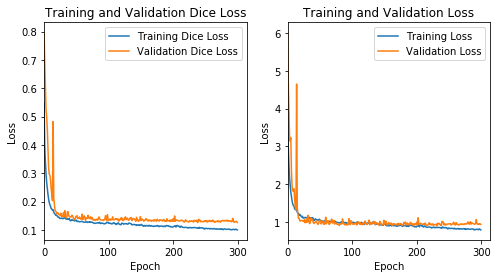

In [73]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, None)
#plt.ylim(0,1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, None)
#plt.ylim(0,1)


plt.savefig('/Users/ryan/growthlaw/unet/training_1011/training_result_20201011.pdf', dpi=200)
plt.show()
plt.close()

## Test predictions

In [75]:
image_output_path = '/Users/ryan/growthlaw/unet/training_1011/test_output'

try:
    os.makedirs(image_output_path)
except:
    print(image_output_path, 'already exists.')

In [76]:
# for the validation data we do no augmentation
test_image_datagen = ImageDataGenerator()
test_image_generator = test_image_datagen.flow(x=phase_imgs,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 seed=seed)

In [77]:
predictions = model.predict_generator(test_image_generator, verbose=1)

130/130 [==============================] - 6s 43ms/step


In [79]:
test_image_generator.reset() # start generator over
n_imgs = predictions.shape[0]
for i in range(n_imgs):

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1/2, target_size[0]/target_size[1]/2), squeeze=False)
    ax = axes.ravel()

    img = test_image_generator.next()[0,:,:,0]
    predicted_label = np.copy(predictions[i,:,:,0])
    predicted_label[predicted_label >= 0.2] = 1
    predicted_label[predicted_label < 0.2] = 0

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].imshow(predicted_label, alpha=0.25, cmap=plt.cm.Greens)

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
    fig.savefig(os.path.join(image_output_path, '{:02d}.png'.format(i)), dpi=200)

#     predicted_label = np.around(predicted_label * 100).astype('uint8')
#     with tiff.TiffWriter(os.path.join(image_output_path, '{:02d}.tif'.format(i)), imagej=False) as tif:
#         tif.save(predicted_label, photometric='minisblack', compress=5)
    
    fig.show()
    plt.close()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
